One of the primary applications of natural language processing is to automatically extract what topics people are discussing from large volumes of text. Some examples of large text could be feeds from social media, customer reviews of hotels, movies, etc, user feedbacks, news stories, e-mails of customer complaints etc.

Knowing what people are talking about and understanding their problems and opinions is highly valuable to businesses, administrators, political campaigns. And it’s really hard to manually read through such large volumes and compile the topics.

Thus is required an automated algorithm that can read through the text documents and automatically output the topics discussed.


*We are working with **gensim** and **mallet** this time*

# 1. Prerequisites – Download nltk stopwords and spacy model

We will be using our own stopwords

In [1]:
# Run in python console
import nltk; nltk.download('stopwords')
import pickle
extra_stopwords = pickle.load(open("extra_stopwords.p", "rb"))
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
import np
from itertools import compress 


[nltk_data] Downloading package stopwords to /home/ubd/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
list(compress(stop_words, [i not in extra_stopwords for i in stop_words]))

[]

In [3]:
## extra_stopwords.extend(list(compress(stop_words, [i not in extra_stopwords for i in stop_words])))
## pickle.dump(extra_stopwords, open("extra_stopwords.p", "wb"))

In [4]:
import re
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)


**LDA’s approach to topic modeling is it considers each document as a collection of topics in a certain proportion. And each topic as a collection of keywords, again, in a certain proportion.**

Once you provide the algorithm with the number of topics, all it does it to rearrange the topics distribution within the documents and keywords distribution within the topics to obtain a good composition of topic-keywords distribution.

When I say topic, what is it actually and how it is represented?

A topic is nothing but a collection of dominant keywords that are typical representatives. Just by looking at the keywords, you can identify what the topic is all about.

The following are key factors to obtaining good segregation topics:

   * The quality of text processing.
   * The variety of topics the text talks about.
   * The choice of topic modeling algorithm.
   * The number of topics fed to the algorithm.
   * The algorithms tuning parameters.

# 2.  Import Newsgroups Data

We will be using the 20-Newsgroups dataset for this exercise. This version of the dataset contains about 11k newsgroups posts from 20 different topics. This is available as newsgroups.json.

This is imported using pandas.read_json and the resulting dataset has 3 columns as shown.

In [5]:
# Import Dataset
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
print(df.target_names.unique())
df.head()

['rec.autos' 'comp.sys.mac.hardware' 'comp.graphics' 'sci.space'
 'talk.politics.guns' 'sci.med' 'comp.sys.ibm.pc.hardware'
 'comp.os.ms-windows.misc' 'rec.motorcycles' 'talk.religion.misc'
 'misc.forsale' 'alt.atheism' 'sci.electronics' 'comp.windows.x'
 'rec.sport.hockey' 'rec.sport.baseball' 'soc.religion.christian'
 'talk.politics.mideast' 'talk.politics.misc' 'sci.crypt']


,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space


In [6]:
# Convert to list
data = df.content.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['From: (wheres my thing) Subject: WHAT car is this!? Nntp-Posting-Host: '
 'rac3.wam.umd.edu Organization: University of Maryland, College Park Lines: '
 '15 I was wondering if anyone out there could enlighten me on this car I saw '
 'the other day. It was a 2-door sports car, looked to be from the late 60s/ '
 'early 70s. It was called a Bricklin. The doors were really small. In '
 'addition, the front bumper was separate from the rest of the body. This is '
 'all I know. If anyone can tellme a model name, engine specs, years of '
 'production, where this car is made, history, or whatever info you have on '
 'this funky looking car, please e-mail. Thanks, - IL ---- brought to you by '
 'your neighborhood Lerxst ---- ']


# 3.  Tokenize words and Clean-up text

Let’s tokenize each sentence into a list of words, removing punctuations and unnecessary characters altogether.

Gensim’s simple_preprocess() is great for this. Additionally I have set deacc=True to remove the punctuations.

In [7]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp', 'posting', 'host', 'rac', 'wam', 'umd', 'edu', 'organization', 'university', 'of', 'maryland', 'college', 'park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']]


# 4. Creating Bigram and Trigram Models

In [8]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])


['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp_posting_host', 'rac_wam_umd_edu', 'organization', 'university', 'of', 'maryland_college_park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front_bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']


# 5. Remove Stopwords, Make Bigrams and Lemmatize

In [9]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in extra_stopwords] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [10]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['thing', 'nntp_poste', 'host', 'park', 'line', 'wonder', 'enlighten', 'car', 'day', 'door', 'sport', 'car', 'look', 'late', 'early', 'call', 'door', 'small', 'addition', 'bumper', 'separate', 'rest', 'body', 'tellme', 'model', 'engine', 'spec', 'year', 'production', 'car', 'history', 'info', 'funky', 'car', 'mail', 'bring', 'neighborhood', 'lerxst']]


# 6. Create the Dictionary and Corpus needed for Topic Modeling

In [11]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 4), (6, 1), (7, 2), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1)]]


Gensim creates a unique id for each word in the document. The produced corpus shown above is a mapping of (word_id, word_frequency).

For example, (0, 1) above implies, word id 0 occurs once in the first document. Likewise, word id 1 occurs twice and so on.

This is used as the input by the LDA model.

If you want to see what word a given id corresponds to, pass the id as a key to the dictionary.

In [12]:
id2word[0]


'addition'

In [13]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]


[[('addition', 1),
  ('body', 1),
  ('bring', 1),
  ('bumper', 1),
  ('call', 1),
  ('car', 4),
  ('day', 1),
  ('door', 2),
  ('early', 1),
  ('engine', 1),
  ('enlighten', 1),
  ('funky', 1),
  ('history', 1),
  ('host', 1),
  ('info', 1),
  ('late', 1),
  ('lerxst', 1),
  ('line', 1),
  ('look', 1),
  ('mail', 1),
  ('model', 1),
  ('neighborhood', 1),
  ('nntp_poste', 1),
  ('park', 1),
  ('production', 1),
  ('rest', 1),
  ('separate', 1),
  ('small', 1),
  ('spec', 1),
  ('sport', 1),
  ('tellme', 1),
  ('thing', 1),
  ('wonder', 1),
  ('year', 1)]]

# 7. Building the Topic Model

In [14]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# 8. View the topics in LDA model

In [15]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]


[(0,
  '0.189*"line" + 0.175*"write" + 0.099*"article" + 0.063*"host" + '
  '0.060*"nntp_poste" + 0.060*"organization" + 0.030*"distribution" + '
  '0.030*"reply" + 0.019*"post" + 0.015*"read"'),
 (1,
  '0.038*"faith" + 0.033*"money" + 0.033*"god" + 0.032*"accept" + 0.031*"love" '
  '+ 0.031*"christian" + 0.031*"die" + 0.030*"religion" + 0.030*"science" + '
  '0.029*"patient"'),
 (2,
  '0.055*"soldier" + 0.049*"village" + 0.034*"turkish" + 0.031*"occupy" + '
  '0.030*"attack" + 0.026*"armenian" + 0.022*"withdraw" + 0.022*"turk" + '
  '0.017*"inhabitant" + 0.017*"side"'),
 (3,
  '0.059*"benefit" + 0.057*"prefer" + 0.049*"grow" + 0.040*"workstation" + '
  '0.036*"collect" + 0.033*"club" + 0.031*"distance" + 0.025*"be" + '
  '0.020*"modem" + 0.020*"campaign"'),
 (4,
  '0.056*"government" + 0.053*"law" + 0.045*"public" + 0.027*"technology" + '
  '0.022*"encryption" + 0.021*"protect" + 0.020*"security" + 0.019*"private" + '
  '0.017*"issue" + 0.017*"break"'),
 (5,
  '0.074*"disk" + 0.047*"c

How to interpret this?

Topic 0 is a represented as _0.016“car” + 0.014“power” + 0.010“light” + 0.009“drive” + 0.007“mount” + 0.007“controller” + 0.007“cool” + 0.007“engine” + 0.007“back” + ‘0.006“turn”.

It means the top 10 keywords that contribute to this topic are: ‘car’, ‘power’, ‘light’.. and so on and the weight of ‘car’ on topic 0 is 0.016.

The weights reflect how important a keyword is to that topic.

Looking at these keywords, can you guess what this topic could be? You may summarise it either are ‘cars’ or ‘automobiles’.

Likewise, can you go through the remaining topic keywords and judge what the topic is?

https://www.machinelearningplus.com/wp-content/uploads/2018/03/Inferring-Topic-from-Keywords.png

# 9. Compute Model Perplexity and Coherence Score

https://rare-technologies.com/what-is-topic-coherence/

In [16]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -14.540720059821176

Coherence Score:  0.42466589222875095


CoherenceModel is from gensim.models

# 10. Visualize the topics-keywords

Now that the LDA model is built, the next step is to examine the produced topics and the associated keywords. There is no better tool than pyLDAvis package’s interactive chart and is designed to work well with jupyter notebooks. **This is actually an R-Library**

In [17]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
15    -0.306053 -0.007302       1        1  24.552586
13    -0.282934  0.039286       2        1  13.235795
16    -0.224316  0.240908       3        1  11.740847
0     -0.155373 -0.295706       4        1   9.551804
18    -0.146537 -0.127960       5        1   6.094372
4     -0.046999  0.161376       6        1   4.654785
8      0.000449 -0.061998       7        1   3.818637
17     0.012357 -0.119657       8        1   3.773460
1     -0.002975  0.070022       9        1   3.707132
6      0.047405 -0.005344      10        1   3.097499
19     0.039523  0.040847      11        1   2.817682
10     0.106717  0.018222      12        1   1.923651
14     0.099959  0.021719      13        1   1.880708
11     0.096941 -0.071478      14        1   1.798727
7      0.052366 -0.002418      15        1   1.710221
2      0.081243  0.094114      16        1   1.450105
12     0.142899 -0.017181      17        1   1.327191
9      0.147420 -0.000055      18        1   1.280885
5      0.150032  0.008638      19        1   1.147364
3      0.187876  0.013965      20        1   0.436547, topic_info=                  Term          Freq         Total Category  logprob  loglift
17                line  14778.000000  14778.000000  Default  30.0000  30.0000
157              write  13727.000000  13727.000000  Default  29.0000  29.0000
141            article   7726.000000   7726.000000  Default  28.0000  28.0000
114             people   8027.000000   8027.000000  Default  27.0000  27.0000
13                host   4920.000000   4920.000000  Default  26.0000  26.0000
...                ...           ...           ...      ...      ...      ...
37173             saku      0.049674      1.382836  Topic20 -11.1842   2.1076
10657             bust      0.049674      1.382859  Topic20 -11.1842   2.1076
24975  buttonpressmask      0.049673      1.382830  Topic20 -11.1842   2.1076
3509              sake      0.049675      1.382884  Topic20 -11.1842   2.1076
3479        commercial      0.049676      1.382935  Topic20 -11.1841   2.1076

[810 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1047      9  0.999111     accept
68        1  0.014631     access
68        5  0.983923     access
733      11  0.465161   accident
733      17  0.531613   accident
...     ...       ...        ...
599      12  0.992753  yesterday
458       9  0.614343      young
458      11  0.219080      young
458      15  0.065877      young
458      16  0.099582      young

[965 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[16, 14, 17, 1, 19, 5, 9, 18, 2, 7, 20, 11, 15, 12, 8, 3, 13, 10, 6, 4])

So how to infer pyLDAvis’s output?

**Each bubble** on the left-hand side plot represents a topic. The larger the bubble, the more prevalent is that topic.

**A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant.**

A model with too many topics, will typically have many overlaps, small sized bubbles clustered in one region of the chart.

Alright, if you move the cursor over one of the bubbles, the words and bars on the right-hand side will update. **These words are the salient keywords** that form the selected topic.

We have successfully built a good looking topic model.

Given our prior knowledge of the number of natural topics in the document, finding the best model was fairly straightforward.

Upnext, we will improve upon this model by using Mallet’s version of LDA algorithm and then we will focus on how to arrive at the optimal number of topics given any large corpus of text.

# 11. Building LDA Mallet Model

So far you have seen Gensim’s inbuilt version of the LDA algorithm. Mallet’s version, however, often gives a better quality of topics.

Gensim provides a wrapper to implement Mallet’s LDA from within Gensim itself. You only need to download the zipfile, unzip it and provide the path to mallet in the unzipped directory to gensim.models.wrappers.LdaMallet. See how I have done this below.

In [18]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = './dependencies/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [19]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(9,
  [('drive', 0.03990616380088165),
   ('problem', 0.03243020288211183),
   ('card', 0.02959449356809569),
   ('work', 0.020649119641153877),
   ('driver', 0.019746848495785105),
   ('bit', 0.018225877136449176),
   ('disk', 0.017375164342244336),
   ('memory', 0.015776855456162513),
   ('fast', 0.015467505349178933),
   ('monitor', 0.014255884096826583)]),
 (7,
  [('gun', 0.02772963604852686),
   ('law', 0.02419220816219938),
   ('state', 0.01866052562854633),
   ('people', 0.017473469290852545),
   ('case', 0.017188575769806036),
   ('crime', 0.012131715771230503),
   ('weapon', 0.010636024785736331),
   ('person', 0.00902162816647278),
   ('police', 0.008997887039718905),
   ('firearm', 0.008238170983594882)]),
 (10,
  [('work', 0.019882296802926674),
   ('money', 0.017064691313140493),
   ('people', 0.016701129314458406),
   ('year', 0.01645118044036447),
   ('pay', 0.012565611579449657),
   ('job', 0.012224772205685202),
   ('government', 0.010111568088345565),
   ('support', 

# 12. **How to find the optimal number of topics for LDA?**

In [20]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [21]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

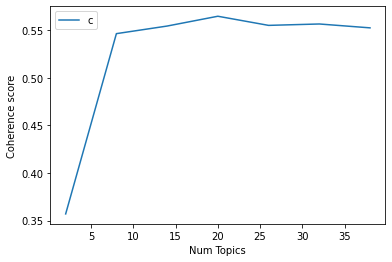

In [22]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [23]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.357
Num Topics = 8  has Coherence Value of 0.5464
Num Topics = 14  has Coherence Value of 0.5544
Num Topics = 20  has Coherence Value of 0.5647
Num Topics = 26  has Coherence Value of 0.5551
Num Topics = 32  has Coherence Value of 0.5566
Num Topics = 38  has Coherence Value of 0.5525


If the coherence score seems to keep increasing, it may make better sense to pick the model that gave the highest CV before flattening out. This is exactly the case here.

So for further steps I will choose the model with 20 topics itself.

In [24]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.220*"line" + 0.123*"host" + 0.118*"nntp_poste" + 0.094*"organization" + '
  '0.056*"write" + 0.046*"reply" + 0.042*"distribution" + '
  '0.012*"distribution_usa" + 0.010*"article" + 0.010*"nntp_posting"'),
 (1,
  '0.021*"work" + 0.019*"year" + 0.012*"group" + 0.010*"program" + '
  '0.009*"plan" + 0.008*"job" + 0.008*"time" + 0.007*"support" + 0.006*"meet" '
  '+ 0.006*"project"'),
 (2,
  '0.025*"question" + 0.019*"exist" + 0.016*"reason" + 0.015*"claim" + '
  '0.015*"evidence" + 0.014*"argument" + 0.013*"true" + 0.012*"people" + '
  '0.011*"human" + 0.010*"answer"'),
 (3,
  '0.010*"food" + 0.009*"doctor" + 0.009*"eat" + 0.008*"day" + 0.008*"patient" '
  '+ 0.008*"problem" + 0.007*"medical" + 0.007*"treatment" + 0.007*"case" + '
  '0.007*"test"'),
 (4,
  '0.028*"point" + 0.018*"time" + 0.017*"number" + 0.014*"problem" + '
  '0.013*"science" + 0.013*"difference" + 0.013*"rate" + 0.012*"thing" + '
  '0.010*"theory" + 0.010*"large"'),
 (5,
  '0.046*"window" + 0.019*"problem" + 0.

In [25]:
# Visualize the topics
pyLDAvis.enable_notebook()
optimal_model_gensim = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)
vis = pyLDAvis.gensim.prepare(optimal_model_gensim, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
8     -0.191708  0.038181       1        1  6.007280
1     -0.067523 -0.084420       2        1  5.889429
2     -0.161763  0.031989       3        1  5.741768
17    -0.154730 -0.001984       4        1  5.687892
6     -0.199999  0.025950       5        1  5.647004
10    -0.178877  0.065390       6        1  5.634238
19     0.107497 -0.088807       7        1  5.500285
18     0.015625 -0.137221       8        1  5.277494
16     0.177453 -0.206094       9        1  5.254945
9      0.059239 -0.127278      10        1  5.094069
4     -0.103813 -0.021065      11        1  5.030921
15    -0.131655  0.113048      12        1  4.848344
5      0.122053 -0.189433      13        1  4.846646
14    -0.045013  0.058912      14        1  4.771438
3     -0.075838 -0.013934      15        1  4.624482
11     0.172444 -0.180223      16        1  4.542229
13     0.046199 -0.002579      17        1  4.404927
7      0.155404  0.314371      18        1  3.979160
12     0.198165  0.087587      19        1  3.932113
0      0.256840  0.317610      20        1  3.285335, topic_info=            Term          Freq         Total Category  logprob  loglift
157        write   9795.000000   9795.000000  Default  30.0000  30.0000
17          line  10189.000000  10189.000000  Default  29.0000  29.0000
141      article   5509.000000   5509.000000  Default  28.0000  28.0000
13          host   3410.000000   3410.000000  Default  27.0000  27.0000
22    nntp_poste   3216.000000   3216.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
23          park     50.570897    107.692998  Topic20  -6.2769   2.6598
997   laboratory     51.543414    172.164873  Topic20  -6.2578   2.2097
2591     college     50.570897    164.307316  Topic20  -6.2769   2.2373
476       center     43.763276    505.908322  Topic20  -6.4214   0.9681
229       packet     38.900690     88.976745  Topic20  -6.5392   2.5883

[1825 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
2132       4  0.966399     abdomen
7287      11  0.988039      absent
272        3  0.994137      absurd
7459      12  0.979632       abyss
354       14  1.040429       accel
...      ...       ...         ...
1235       4  0.966399      yehiam
14473     20  0.988711  youngstown
7487      18  1.025081     zillion
3980       9  0.991005         zip
3980      20  0.015730         zip

[3514 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 2, 3, 18, 7, 11, 20, 19, 17, 10, 5, 16, 6, 15, 4, 12, 14, 8, 13, 1])

In [26]:
# Visualize the topics
pyLDAvis.enable_notebook()
optimal_model_gensim2 = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(model_list[2])
vis = pyLDAvis.gensim.prepare(optimal_model_gensim2, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
11     0.057777 -0.250119       1        1  9.034280
6     -0.217324  0.064166       2        1  8.974296
2     -0.229636  0.043258       3        1  8.330161
7     -0.157529  0.130462       4        1  8.219774
4     -0.136184  0.005037       5        1  7.680895
8     -0.038298 -0.162600       6        1  7.366549
5     -0.049583 -0.154890       7        1  7.305306
12     0.010282  0.203940       8        1  6.916946
9     -0.032426 -0.065882       9        1  6.731798
1      0.016671  0.125571      10        1  6.281372
3      0.066300  0.045806      11        1  6.274974
10     0.168643 -0.215903      12        1  6.220521
0      0.231047 -0.012490      13        1  5.679545
13     0.310260  0.243642      14        1  4.983584, topic_info=            Term          Freq         Total Category  logprob  loglift
157        write   9678.000000   9678.000000  Default  30.0000  30.0000
17          line  10077.000000  10077.000000  Default  29.0000  29.0000
141      article   5433.000000   5433.000000  Default  28.0000  28.0000
13          host   3353.000000   3353.000000  Default  27.0000  27.0000
22    nntp_poste   3166.000000   3166.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
1525         net    152.828684    727.512850  Topic14  -5.5876   1.4387
1755     keyword    122.262947    444.735065  Topic14  -5.8107   1.7077
2402         ago     80.235059    237.250062  Topic14  -6.2320   1.9149
436     previous     91.697211    409.732301  Topic14  -6.0984   1.5020
1366        wait     70.683266    430.215080  Topic14  -6.3587   1.1929

[1253 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
732      11  0.984471         abs
368       2  1.001240    absolute
3938      5  0.193324  absolutely
3938      8  0.799659  absolutely
3938     10  0.004394  absolutely
...     ...       ...         ...
33        5  0.323951        year
33        6  0.088268        year
33        9  0.031524        year
33       10  0.460256        year
1235      5  0.948075      yehiam

[2190 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 7, 3, 8, 5, 9, 6, 13, 10, 2, 4, 11, 1, 14])

In [31]:
pyLDAvis.save_html(vis, "pyldavis_deneme.html")

# 12. Finding the dominant topic in each sentence

One of the practical application of topic modeling is to determine what topic a given document is about.

To find that, we find the topic number that has the highest percentage contribution in that document.

The format_topics_sentences() function below nicely aggregates this information in a presentable table.

In [27]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,13.0,0.1751,"car, ride, bike, engine, turn, drive, light, s...",From: (wheres my thing) Subject: WHAT car is t...
1,1,11.0,0.1557,"drive, card, problem, bit, work, driver, disk,...",From: (Guy Kuo) Subject: SI Clock Poll - Final...
2,2,11.0,0.1115,"drive, card, problem, bit, work, driver, disk,...",From: (Thomas E Willis) Subject: PB questions....
3,3,7.0,0.0953,"write, article, line, read, hear, post, opinio...",From: (Joe Green) Subject: Re: Weitek P9000 ? ...
4,4,5.0,0.1549,"window, problem, application, set, work, progr...",From: (Jonathan McDowell) Subject: Re: Shuttle...
5,5,17.0,0.2677,"law, state, government, gun, people, case, cri...",From: (Foxvog Douglas) Subject: Re: Rewording ...
6,6,19.0,0.1232,"file, post, address, list, send, number, email...",From: (brian manning delaney) Subject: Brain T...
7,7,11.0,0.4441,"drive, card, problem, bit, work, driver, disk,...",From: (GRUBB) Subject: Re: IDE vs SCSI Organiz...
8,8,5.0,0.0956,"window, problem, application, set, work, progr...",From: Subject: WIn 3.0 ICON HELP PLEASE! Organ...
9,9,11.0,0.1399,"drive, card, problem, bit, work, driver, disk,...",From: (Stan Kerr) Subject: Re: Sigma Designs D...


# 13. Find the most representative document for each topic

In [28]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.7549,"line, host, nntp_poste, organization, write, r...",Subject: roman 02/14 From: (Cliff) Reply-To: (...
1,1.0,0.7477,"work, year, group, program, plan, job, time, s...",From: (Clinton/Gore 92) Subject: CLINTON: Back...
2,2.0,0.6368,"question, exist, reason, claim, evidence, argu...",From: mathew Subject: Alt.Atheism FAQ: Constru...
3,3.0,0.6810,"food, doctor, eat, day, patient, problem, medi...","From: Subject: Candida(yeast) Bloom, Fact or F..."
4,4.0,0.5486,"point, time, number, problem, science, differe...",From: (James Foster x2912) Subject: Re: My Gun...


In [29]:
# pprint(sent_topics_sorteddf_mallet.iloc[4,3])

# 14.Topic distribution across documents

In [30]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,13.0,"car, ride, bike, engine, turn, drive, light, s...",875.0,0.0773
1.0,11.0,"drive, card, problem, bit, work, driver, disk,...",243.0,0.0215
2.0,11.0,"drive, card, problem, bit, work, driver, disk,...",471.0,0.0416
3.0,7.0,"write, article, line, read, hear, post, opinio...",492.0,0.0435
4.0,5.0,"window, problem, application, set, work, progr...",181.0,0.0160
...,...,...,...,...
11309.0,3.0,"food, doctor, eat, day, patient, problem, medi...",NaN,NaN
11310.0,11.0,"drive, card, problem, bit, work, driver, disk,...",NaN,NaN
11311.0,11.0,"drive, card, problem, bit, work, driver, disk,...",NaN,NaN
11312.0,4.0,"point, time, number, problem, science, differe...",NaN,NaN
